<a href="https://colab.research.google.com/github/seonghyeock/CNN_Exercise/blob/main/VisualizingLayers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [ ]:
# MNIST 데이터셋 불러오기
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)
print(x_test.shape)

# 이미지를 학습시키므로 채널을 추가해야 한다. 컬러 이미지의 경우 채널의 개수가 3이므로(RGB) 3이 추가되며 흑백 이미지는 1이 추가된다.
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
print(x_train.shape)
print(x_test.shape)

# 데이터 전처리
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

(60000, 28, 28)
(10000, 28, 28)
(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [ ]:
# CNN 모델 생성
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 훈련
model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/5
938/938 [==============================] - 46s 48ms/step - loss: 0.1735 - accuracy: 0.9476 - val_loss: 0.0500 - val_accuracy: 0.9834
Epoch 2/5
938/938 [==============================] - 45s 48ms/step - loss: 0.0512 - accuracy: 0.9843 - val_loss: 0.0369 - val_accuracy: 0.9875
Epoch 3/5
938/938 [==============================] - 43s 46ms/step - loss: 0.0364 - accuracy: 0.9892 - val_loss: 0.0423 - val_accuracy: 0.9864
Epoch 4/5
938/938 [==============================] - 47s 50ms/step - loss: 0.0277 - accuracy: 0.9911 - val_loss: 0.0318 - val_accuracy: 0.9901
Epoch 5/5
938/938 [==============================] - 49s 52ms/step - loss: 0.0223 - accuracy: 0.9925 - val_loss: 0.0371 - val_accuracy: 0.9877


1/1 [==============================] - 0s 107ms/step
32
32
64
64


<ipython-input-10-cbfd5adcbce0>:31: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()  # 표준 편차 정규화
<ipython-input-10-cbfd5adcbce0>:34: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


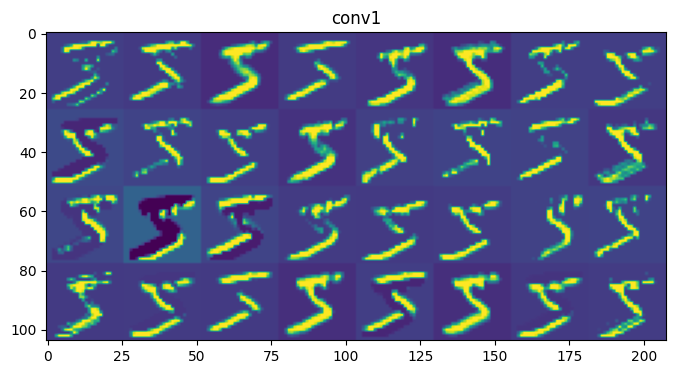

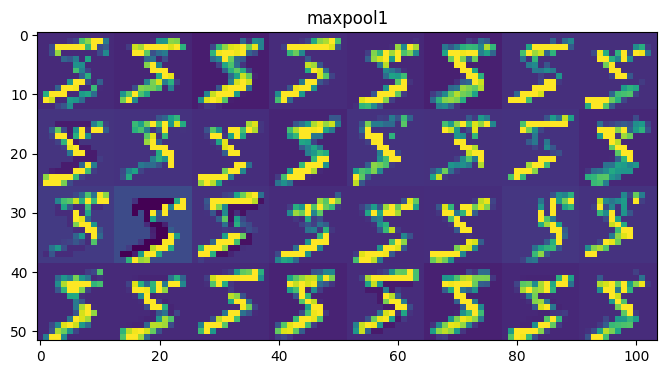

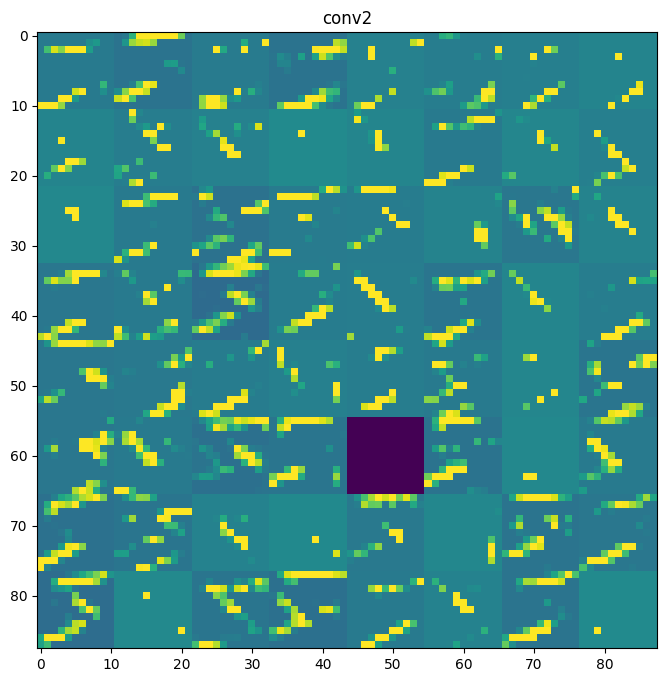

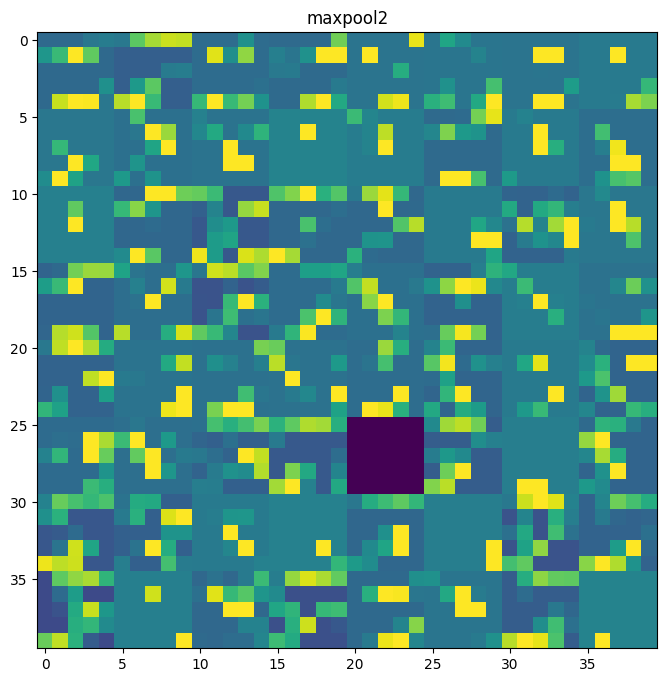

In [ ]:
# 각 레이어의 활성화 시각화
layer_outputs = [layer.output for layer in model.layers[:4]]  # 첫 4개의 레이어 선택하여 출력을 저장한다.

# 입력 이미지를 입력으로 받고 선택된 레이어를 통과한 것을 출력으로 하는 모델을 생성한다.
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

sample_image = x_train[0][np.newaxis, ...]  # 훈련 데이터 중 첫 번째 이미지를 샘플 이미지로 선택한다.

# (28, 28) 크기의 이미지가 (1, 28, 28,1 )로 변환된다.
# print(sample_image.shape)

activations = activation_model.predict(sample_image)

# 각 레이어의 활성화 시각화
layer_names = ['conv1', 'maxpool1', 'conv2', 'maxpool2']
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]  # 특성 맵의 개수, 필터를 거쳐 나온 것이 특성 맵이므로 필터의 개수와 특성 맵의 수는 같다.
    # print(n_features)

    # 특성 맵을 그리드로 표시
    size = layer_activation.shape[1] # 특성 맵의 크기(가로 또는 세로 길이, 보통 특성 맵은 정사각형임)
    n_cols = n_features // 8  # 그리드 열 개수
    display_grid = np.zeros((size * n_cols, 8 * size)) # 일단은 빈 그리드로 초기화한다.

    for col in range(n_cols):  # 각 열에 대해 반복
        for row in range(8):  # 각 행에 대해 반복
            channel_image = layer_activation[0,
                                             :, :,
                                             col * 8 + row] # 각 열과 행에 맞는 특성 맵을 선택
            channel_image -= channel_image.mean()  # 평균 중심화
            channel_image /= channel_image.std()  # 표준 편차 정규화
            channel_image *= 64  # 이미지를 [0, 64] 범위로 스케일
            channel_image += 128  # [0, 64]를 [0, 255]로 스케일
            channel_image = np.clip(channel_image, 0, 255).astype('uint8') # 0 또는 255를 초과하는 픽셀 값에 대하여 조절함
            display_grid[col * size : (col + 1) * size,  # 그리드의 특정 위치에 특성 맵을 삽입
                         row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)

    # aspect: 'auto'이면 종횡비를 자동으로 설정한다.
    # cmap: 'viridis'이면 낮은 값은 파란색, 높은 값은 노란색으로 표시한다. 시각화에 주로 사용한다.
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()